In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [37]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [4]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [34]:
def plot(self, model=None, plot_col='CLOSE', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [6]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [7]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [54]:
MAX_EPOCHS = 5

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [77]:
eurUsd = pd.read_csv('EURUSD.txt')
eurUsd['VOL'] = eurUsd['VOL'].shift(1)

In [80]:
eurUsd.fillna(0,inplace=True)
eurUsd.head(10)

,TICKER,DTYYYYMMDD,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,EURUSD,20010102,230100,0.9507,0.9507,0.9507,0.9507,0.0
1,EURUSD,20010102,230200,0.9506,0.9506,0.9505,0.9505,4.0
2,EURUSD,20010102,230300,0.9505,0.9507,0.9505,0.9506,4.0
3,EURUSD,20010102,230400,0.9506,0.9506,0.9506,0.9506,4.0
4,EURUSD,20010102,230500,0.9506,0.9506,0.9506,0.9506,4.0
5,EURUSD,20010102,230600,0.9506,0.9506,0.9506,0.9506,4.0
6,EURUSD,20010102,230700,0.9505,0.9507,0.9505,0.9507,4.0
7,EURUSD,20010102,230800,0.9507,0.9507,0.9507,0.9507,4.0
8,EURUSD,20010102,230900,0.9507,0.9507,0.9507,0.9507,4.0
9,EURUSD,20010102,231000,0.9507,0.9507,0.9507,0.9507,4.0


In [81]:
eurUsd['DTYYYYMMDD'] = eurUsd[['DTYYYYMMDD']].applymap(str).applymap(lambda s: "{}/{}/{}".format(s[4:6],s[6:], s[0:4]))

In [82]:
eurUsd['TIME'] = eurUsd[['TIME']].applymap(str).applymap(lambda s: s.zfill(6))
eurUsd['TIME'] = eurUsd[['TIME']].applymap(str).applymap(lambda s: "{}:{}:{}".format(s[0:2],s[2:4], s[4:6]))

In [83]:
eurUsd['Date'] = eurUsd['DTYYYYMMDD'] + ' ' + eurUsd['TIME']

In [84]:
eurUsd['Date'] = eurUsd[['Date']].applymap(str).applymap(lambda s: datetime.strptime(s,"%m/%d/%Y %H:%M:%S"))
eurUsd['Date'] = pd.to_datetime(eurUsd['Date'])
timestamp_s = eurUsd['Date'].map(pd.Timestamp.timestamp)
eurUsd.drop(columns=['Date','TICKER','DTYYYYMMDD','TIME','HIGH','LOW'],axis=1,inplace=True)

In [85]:
hour = 24*60

eurUsd['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
eurUsd['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
eurUsdWOHour = eurUsd.drop(columns=['Hour sin','Hour cos'], axis=1)

Text(0.5, 1.0, 'Time of day signal')

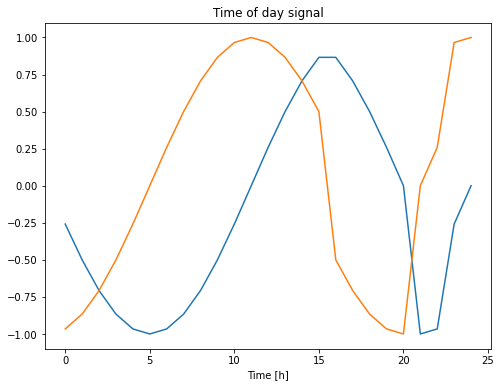

In [86]:
plt.plot(np.array(eurUsd['Hour sin'])[:25])
plt.plot(np.array(eurUsd['Hour cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [87]:
scaler = StandardScaler()
eurUsdWOHour = pd.DataFrame(scaler.fit_transform(eurUsdWOHour),columns=eurUsdWOHour.columns)

In [88]:
column_indices = {name: i for i, name in enumerate(eurUsdWOHour.columns)}

n = len(eurUsdWOHour)
train_df = eurUsdWOHour[0:int(n*0.7)]
val_df = eurUsdWOHour[int(n*0.7):int(n*0.9)]
test_df = eurUsdWOHour[int(n*0.9):]

num_features = eurUsdWOHour.shape[1]

In [89]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, train_df=train_df,val_df=val_df, test_df=test_df,label_columns=None)

In [90]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 3)


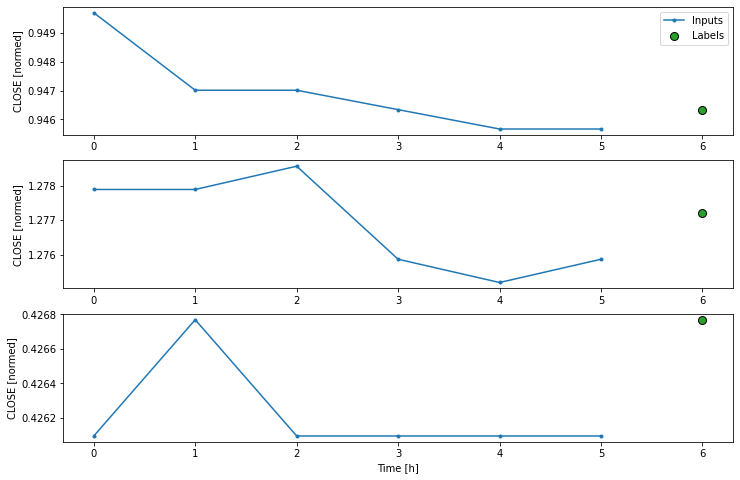

In [91]:
w2.plot()

In [92]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,train_df=train_df,val_df=val_df, test_df=test_df)

In [93]:
baseline = Baseline()

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

45566/45566 [==============================] - 76s 2ms/step - loss: 7.8135e-07 - mean_absolute_error: 4.1863e-04


In [94]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,train_df=train_df,val_df=val_df, test_df=test_df)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): None

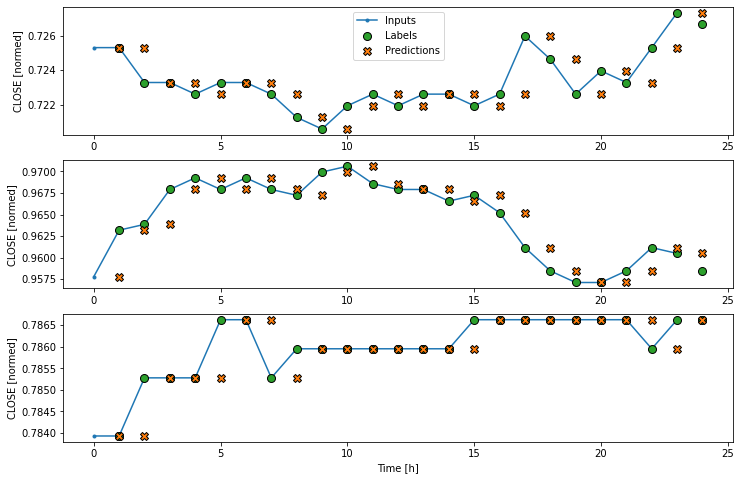

In [95]:
wide_window.plot(baseline)

In [96]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [97]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/5
159480/159480 [==============================] - 331s 2ms/step - loss: 2.0118 - mean_absolute_error: 0.3960 - val_loss: 0.1070 - val_mean_absolute_error: 0.2798
Epoch 2/5
159480/159480 [==============================] - 331s 2ms/step - loss: 1.9135 - mean_absolute_error: 0.3961 - val_loss: 0.1070 - val_mean_absolute_error: 0.2799solute
Epoch 3/5
45566/45566 [==============================] - 80s 2ms/step - loss: 0.1070 - mean_absolute_error: 0.2800


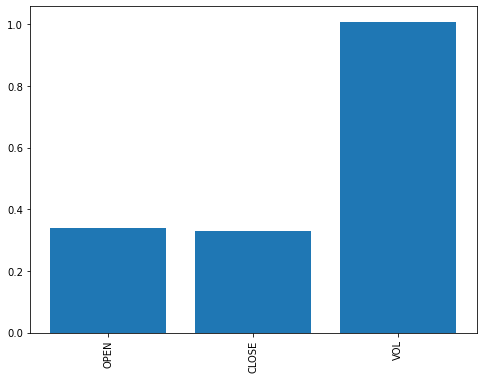

In [98]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [99]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/5
159480/159480 [==============================] - 430s 3ms/step - loss: 0.2772 - mean_absolute_error: 0.3954 - val_loss: 0.1070 - val_mean_absolute_error: 0.2799
Epoch 2/5
159480/159480 [==============================] - 442s 3ms/step - loss: 0.5192 - mean_absolute_error: 0.3956 - val_loss: 0.1070 - val_mean_absolute_error: 0.2803
Epoch 3/5
45566/45566 [==============================] - 77s 2ms/step - loss: 0.1070 - mean_absolute_error: 0.2800


In [100]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,train_df=train_df,val_df=val_df, test_df=test_df)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): None

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

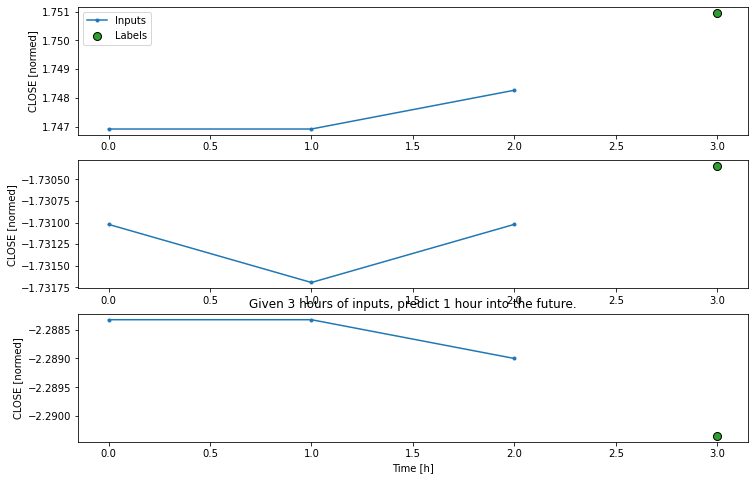

In [101]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [102]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [103]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 3)
Output shape: (32, 1, 1)


In [104]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

45566/45566 [==============================] - 80s 2ms/step - loss: 0.1070 - mean_absolute_error: 0.2801


In [107]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [108]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 3)
Output shape: (32, 1, 1)


In [109]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

45566/45566 [==============================] - 66s 1ms/step - loss: 0.1070 - mean_absolute_error: 0.2803


In [110]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 3)
Labels shape: (32, 24, 3)
Output shape: (32, 22, 1)


In [111]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,train_df=train_df,val_df=val_df, test_df=test_df)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): None

In [112]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 3)
Labels shape: (32, 24, 3)
Output shape: (32, 24, 1)


In [114]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [115]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


In [116]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

45565/45565 [==============================] - 180s 4ms/step - loss: 0.1070 - mean_absolute_error: 0.2800


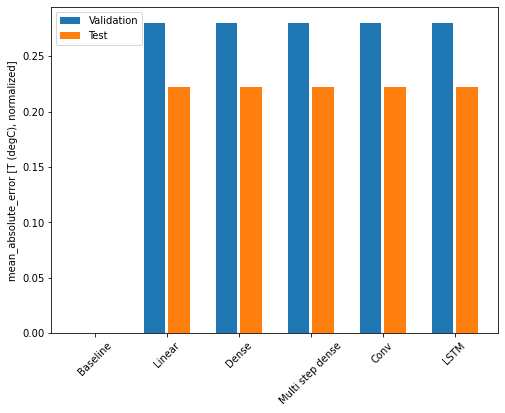

In [118]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()